![Astrofisica Computacional](../logo.PNG)

---
## 25. El problema del sobre-ajuste de los Árboles de Decisión.


Eduard Larrañaga (ealarranaga@unal.edu.co)

---

### Resumen

En este cuaderno se ilustrará el problema del sobre-ajuste de los árboles de decisión.

---

El sobre-ajuste de datos hace referencia a que un algoritmo intenta incorporar todos los puntos del conjunto de datos (incluso los más aislados). Esto puede tener como consecuencia que se pierde el poder de predicción general. 


En este cuaderno ilustraremos estos inconvenientes en el algoritmo de árbol de decisión cuando su entrenamiento no se supervisa.

### Cargando los datos

De nuevo utilizaremos el archivo `'sdss_galaxy_colors.npy'`con los datos fotométricos de las galaxias. 


In [1]:
import numpy as np

data = np.load('sdss_galaxy_colors.npy')
data

array([(19.84132, 19.52656, 19.46946, 19.17955, 19.10763, b'QSO', 0.539301  , 6.543622e-05),
       (19.86318, 18.66298, 17.84272, 17.38978, 17.14313, b'GALAXY', 0.1645703 , 1.186625e-05),
       (19.97362, 18.31421, 17.47922, 17.0744 , 16.76174, b'GALAXY', 0.04190006, 2.183788e-05),
       ...,
       (19.82667, 18.10038, 17.16133, 16.5796 , 16.19755, b'GALAXY', 0.0784592 , 2.159406e-05),
       (19.98672, 19.75385, 19.5713 , 19.27739, 19.25895, b'QSO', 1.567295  , 4.505933e-04),
       (18.00024, 17.80957, 17.77302, 17.72663, 17.7264 , b'QSO', 0.4749449 , 6.203324e-05)],
      dtype=[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('spec_class', 'S6'), ('redshift', '<f8'), ('redshift_err', '<f8')])

Las características incorporados en el conjunto de datos son:

| dtype | Feature|
|:-:|:-:|
|`u` |u band filter|
|`g` |g band filter|
|`r` |r band filter|
|`i` |i band filter|
|`z` |z band filter|
|`spec_class` |spectral class|
|`redshift` |redshift|
|`redshift_err` |redshift error|


El número de galaxias en el conjunto es

In [2]:
n = data.size
n

50000

---
### Entrenamiento del Árbol de Decisión

Como se vió en la práctica anterior, los árboles de decisión tienen ventajas como

- Son fáciles de implementar 
- Son fáciles de interpretar
- Los datos no requieren mucha preparación 
- Usualmente los árboles de decisión son eficientes computacionalmente.

Sin embargo, los árboles de decisión también tienen limitaciones. La mayor de ellas es que tienden a sobre-ajustar los datos si no se supervisa el proceso de entrenamiento. Con el sobre-ajuste, se intentará crear un árbol supercomplicado que intenta dar cuenta de todos los datos de entrada. 


El primer paso para el entrenamiento del árbol es definir los conjuntos de entrada 'features' y 'targets'.

In [3]:
# Function returning the 4 color indices and the redshifts
import numpy as np

features, targets = np.asarray([data['u']-data['g'],\
                                data['g']-data['i'],\
                                data['r']-data['i'],\
                                data['i']-data['z']]), \
                    np.asarray(data['redshift'])

In [4]:
targets.shape

(50000,)

In [5]:
features.shape

(4, 50000)

In [6]:
features = features.T
features.shape

(50000, 4)

Luego, deben dividirse estos arreglos en los subconjuntos de entrenamiento y prueba. Puede escogerse una división de (50:50)

In [7]:
split_n = n//2
train_features = features[:split_n]
test_features = features[split_n:]
train_targets = targets[:split_n]
test_targets = targets[split_n:]

In [8]:
display(train_features.shape, 
        test_features.shape, 
        train_targets.shape, 
        test_targets.shape)

(25000, 4)

(25000, 4)

(25000,)

(25000,)

Ahora se utilizará de nuevo la función `sklearn.tree.DecisionTreeRegressor`. Sin embargo, en esta ocasión se utilizará el argumento **tree depth** para reducir el sobre-ajuste. Este argumento restringe el número de nodos en el árbol. Incialmente, definiremos una profundidad máxima de 5,

In [9]:
from sklearn.tree import DecisionTreeRegressor

dec_tree = DecisionTreeRegressor(max_depth=5)


Utilizando el método `.fit()` se entrenará el algoritmo utilizando los subconjuntos correspondientes.

Información detallada de los árboles de decisión se puede encontrar en 

https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html

In [10]:
dec_tree.fit(train_features, train_targets)

DecisionTreeRegressor(max_depth=5)

#### Prueba del Árbol de Decisión

Una vez que se construye en árbol de decisión, se aplicará el método `.predict()` sobre el conjunto de prueba,

In [11]:
predictions = dec_tree.predict(test_features)

Al igual que se hizo anteriormente, se utilizará la mediana de los residuos para medir la precisión del algoritmo,

\begin{equation}
\text{eval_dec_tree} = \text{median}\left\lbrace \left| \text{predictions}_i - \text{targets}_i \right|\right\rbrace
\end{equation}



In [12]:
eval_dec_tree = np.median(np.abs(predictions - test_targets))
eval_dec_tree

0.03756328502826199

#### Sobre-Ajuste y Profundidad del Árbol 

Para observar el sobre-ajuste de los datos, se examinará el papel de la profundidad del árbol en la precisión del ajuste. Se podría esperar que a mayor profundidad, mejor sería la precisión. Sin embargo, una mayor profundidad resultará en un sobre-ajuste de los datos de entrenamiento que a su vez implicará una menor precisión en la predicción del algoritmo.

**1. Defina una función que cree el árbol de decisión  con profundidades en el rango de 0 a 40. La función debe predecir el corrimiento al rojo de los conjuntos de entrenamiento y de prueba y calcular la mediana de los residuos para evaluar el algoritmo.**

Recapitulando, los datos de índices de color y $z$ están en los arreglos `features` y `targets`, respectivamente. Además, los conjuntos de entrenamiento y prueba son `train_features`, `test_features`, `train_targets`, y
 `test_targets`, respectivamente.
 
Ahora, procedamos a crear un método (o función) llamado `CreateDecisionTree()`. Este método hará tres tareas:
1. Crear el árbol de decisión para una profundidad dada.
2. Hacer la predicción (del $z$) para los conjuntos de entrenamiento y de prueba.
3. Calcular la media (para ambas predicciones).

In [13]:
def CreateDecisionTree(depth, 
                       X, X_test, y, y_test):
    '''
    ------------------------------------------
    CreationDecisionTree()
    ------------------------------------------
    Create a decision tree from the scikit 
    learn package given a depth, make a 
    prediction, compute the median between
    the prediction and the test target set, and
    return the median.
    
    Input:
        depth:  the depth of the three
        X:      train features
        X_test: test features
        y:      train targets
        y_test: test targets        
    
    Output: 
        median: the median between the predic-
        tion and the test target set.
    ------------------------------------------
    '''
    import numpy as np
    from sklearn.tree import DecisionTreeRegressor
    
    # Fit regression model
    regr = DecisionTreeRegressor(max_depth=depth)    
    regr.fit(X, y)

    # Predict
    y_predict      = regr.predict(X)
    y_predict_test = regr.predict(X_test)

    # Compute the median
    m_training   = np.median(np.abs(y_predict - y))
    m_validation = np.median(np.abs(y_predict_test - y_test))
    
    return m_training, m_validation

Bien, ahora vamos a usar el método para calcular la mediana, dada las profundidades de 0 a 40. (Note que la profundidad debe ser mayor que cero, de acuerdo con la descrición del método `DecisionTreeRegressor()` del paquete `tree` de `sklearn`).

In [16]:
import numpy as np

depth = np.linspace(2, 40, 100, endpoint=True)  # num=40 is enough
m_t = np.zeros(len(depth))    # median_training
m_v = np.zeros(len(depth))    # median_validation

for i in range(0, len(depth)):    
    m_t[i], m_v[i] = CreateDecisionTree(depth = depth[i], 
                                        X = train_features,
                                        X_test = test_features, 
                                        y = train_targets, 
                                        y_test = test_targets) 

**2. Grafique la mediana de los residuos vs profundidad del árbol.**

El gráfico debe lucir como este:

<center>
<img src="https://groklearning-cdn.com/problems/8Cet6iLGMbP2L8t7SVkEEg/overfitting.png" width=450>
</center>

Este gráfico muestra como la precisión sobre el conjunto de entrenamiento mejora con la profundidad. En efecto,  **para profundidades superiores a 27, el error es cero!**

Sin embargo, la predicción sobre el conjunto de prueba mejora inicialmente, pero luego empeora para grandes profundidades. Como se puede observar de la figura, para profundidades mayores que 19, el arbol de decisión comienza a presentar un sobre-ajuste de los datos de entrenamiento que se manifiesta como un aumento en el error de las predicciones en el conjunto de prueba. 

De acuerdo con esta información, para el conjunto de datos de galaxias es posible prevenir el sobre-ajuste al utilziar una profundidad máxima alrededor de 19 o 20.

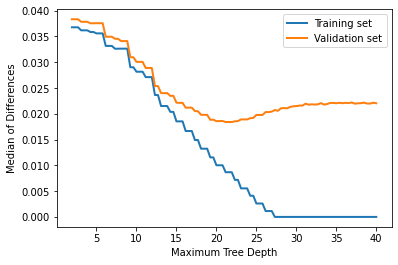

In [20]:
# Plot the results
from matplotlib import pyplot as plt

plt.figure()
plt.plot(depth, m_t, label="Training set", linewidth=2)
plt.plot(depth, m_v, label="Validation set", linewidth=2)
plt.xlabel("Maximum Tree Depth")
plt.ylabel("Median of Differences")
plt.legend()
plt.show()

¡Excelente! Nuestra gráfica luce algo parecida a la esperada, salvo que la nuestra tiene mayor densidad de puntos y nuestro punto crítico está alrededor de una profundidad del árbol de 21.